# Import Libraries

In [2]:
import time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [6]:
batch_size = 100
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Visualization

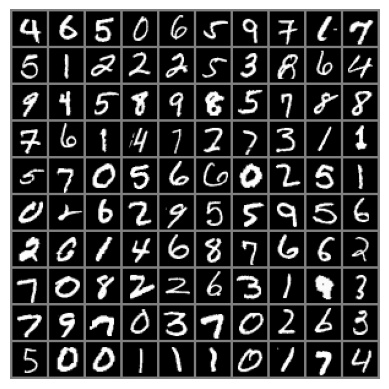

In [7]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.show()

imshow(make_grid(images, nrow=10))

# Hopfield Network

In [8]:
class HopfieldNetwork:
    def __init__(self, rule="hebbian"):
        self.n = patterns[0].numel()
        self.order = torch.arange(self.n)
        self.rule = rule

    def train(self, patterns):
        if self.rule == "hebbian":
            self.weights = torch.zeros((self.n, self.n))
            for p in patterns:
                p = p.view(-1, 1)
                self.weights += torch.mm(p, p.T)

            self.weights.fill_diagonal_(0)

        elif self.rule == "pseudo":
            c = torch.tensordot(patterns, patterns, dims=([1], [1])) / len(patterns)
            cinv = torch.linalg.inv(c)
            self.weights = torch.zeros((self.n, self.n))

            for k, l in itertools.product(range(len(patterns)), range(len(patterns))):
                self.weights += cinv[k, l] * torch.outer(patterns[k], patterns[l])

            self.weights /= len(patterns)

        elif self.rule == "storkey":
            self.weights = torch.zeros((self.n, self.n))

            for pattern in patterns:
                h = torch.mv(self.weights, pattern)
                hebbian = torch.outer(pattern, pattern)
                self_interaction = torch.outer(h, pattern) + torch.outer(pattern, h)
                self.weights += hebbian - self_interaction / self.n
            
            self.weights /= len(patterns)
            self.weights[self.order, self.order] = 0.0

    def recall(self, pattern, steps=10):
        recalled = pattern.clone()
        for _ in range(steps):
            recalled = torch.sign(torch.mv(self.weights, recalled))

        return recalled

# Train

In [9]:
images, _ = next(iter(train_dataloader))
images = images.squeeze(1)
patterns = torch.stack([torch.sign(image.flatten()) for image in images])

In [10]:
hn_hebbian = HopfieldNetwork(rule="hebbian")
hn_hebbian.train(patterns)

In [11]:
hn_pseudo = HopfieldNetwork(rule="pseudo")
hn_pseudo.train(patterns)

In [12]:
hn_storkey = HopfieldNetwork(rule="storkey")
hn_storkey.train(patterns)

# Results

In [33]:
test_pattern = patterns[1].clone()

In [34]:
noisy_pattern = test_pattern.clone()
noisy_indices = torch.randperm(test_pattern.numel())[:50]
noisy_pattern[noisy_indices] *= -1

In [35]:
recalled_pattern1 = hn_hebbian.recall(noisy_pattern)
recalled_pattern2 = hn_pseudo.recall(noisy_pattern)
recalled_pattern3 = hn_storkey.recall(noisy_pattern)

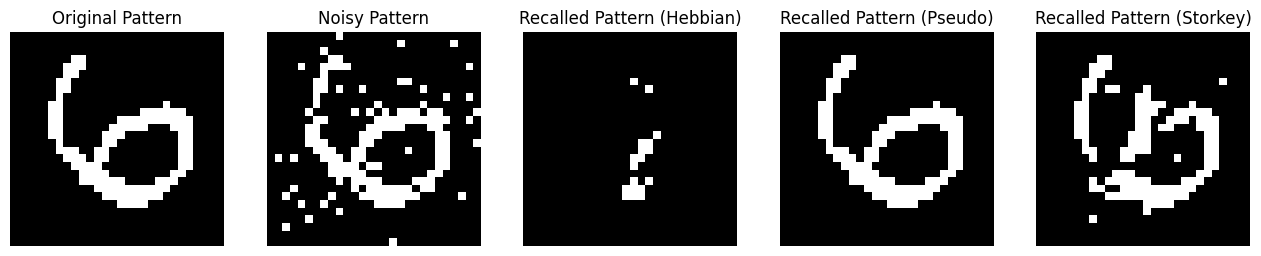

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].imshow(test_pattern.view(28, 28), cmap='gray')
axes[0].set_title("Original Pattern")
axes[0].axis("off")

axes[1].imshow(noisy_pattern.view(28, 28), cmap='gray')
axes[1].set_title("Noisy Pattern")
axes[1].axis("off")

axes[2].imshow(recalled_pattern1.view(28, 28), cmap='gray')
axes[2].set_title("Recalled Pattern (Hebbian)")
axes[2].axis("off")

axes[3].imshow(recalled_pattern2.view(28, 28), cmap='gray')
axes[3].set_title("Recalled Pattern (Pseudo)")
axes[3].axis("off")

axes[4].imshow(recalled_pattern3.view(28, 28), cmap='gray')
axes[4].set_title("Recalled Pattern (Storkey)")
axes[4].axis("off")

plt.show()